In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

c:\Users\Zephyrus\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Zephyrus\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
c:\Users\Zephyrus\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:

# Database connection parameters
db_params = {
    'dbname': 'integration',
    'user': 'postgres',
    'password': '1234',
    'host': 'localhost',
    'port': '5432'
}


In [3]:
# Establishing the connection
conn = psycopg2.connect(**db_params)

# Define your SQL query
query = "SELECT * FROM db_events;"

# Execute the query and store the result in a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Display the DataFrame
print(df.head())

C:\Users\Zephyrus\AppData\Local\Temp\ipykernel_9592\3958174467.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


   duracion       fecha  hora  esquema                tabla  \
0        38  2024-06-01     0  sat_fel  p_dte_emisor_gtq_ag   
1        42  2024-06-01     0  sat_fel  p_dte_emisor_gtq_ag   
2        27  2024-06-01     0  sat_fel  p_dte_emisor_gtq_ag   
3        15  2024-06-01     0  sat_fel  p_dte_emisor_gtq_ag   
4        21  2024-06-01     0  sat_fel  p_dte_emisor_gtq_ag   

                                    app  Day of month  ID Day of week  \
0  2ff814a6-3304-4ab8-85cb-cd0e6f879c1d             1               7   
1  2ff814a6-3304-4ab8-85cb-cd0e6f879c1d             1               7   
2  2ff814a6-3304-4ab8-85cb-cd0e6f879c1d             1               7   
3  2ff814a6-3304-4ab8-85cb-cd0e6f879c1d             1               7   
4  2ff814a6-3304-4ab8-85cb-cd0e6f879c1d             1               7   

  Day of week    mean_st  ...  rango_final_by_table  tamañano_resp_by_table  \
0      sábado  28.165406  ...          7.980910e+07            2.439692e+06   
1      sábado  28.165406

In [4]:
df.columns

Index(['duracion', 'fecha', 'hora', 'esquema', 'tabla', 'app', 'Day of month',
       'ID Day of week', 'Day of week', 'mean_st', 'std_st', 'min', 'max',
       'rango_inicial_by_table', 'rango_final_by_table',
       'tamañano_resp_by_table', 'min_boundary', 'b_ound', 'Periodo Del Mes',
       'Evento del Dia', 'pre_clasificacion', 'latencia_by_day_month',
       'latencia_by_day_week', 'SimultJobs'],
      dtype='object')

In [5]:
d_row = df[df['pre_clasificacion'] == 'NORMAL']

# Randomly select 50% of those rows
np.random.seed(0)  # For reproducibility
sample_rows_d = d_row.sample(frac=1) #0.7

# Drop the selected rows from the original DataFrame
df = df.drop(sample_rows_d.index)

In [6]:
df_filtered = df[df['duracion'] <= 70]

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

selected_cols = df_filtered[['tabla', 'app', 'Day of month',
       'ID Day of week',
       'tamañano_resp_by_table',
       'hora',  'latencia_by_day_month',
       'latencia_by_day_week', 'SimultJobs','duracion']]

categorical_columns = ['tabla','app',]
numeric_columns = ['ID Day of week','SimultJobs','Day of month','hora'
                   ,'tamañano_resp_by_table','latencia_by_day_month','latencia_by_day_week']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ])


encoded_data = preprocessor.fit_transform(selected_cols)

X = encoded_data
y = selected_cols['duracion']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Fit a regression tree model
reg_ln = LinearRegression()
reg_ln.fit(X_train, y_train)

# Predict for the test data
y_pred_ln = reg_ln.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_ln)
r2 = r2_score(y_test, y_pred_ln)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 68.67
R-squared: 0.30


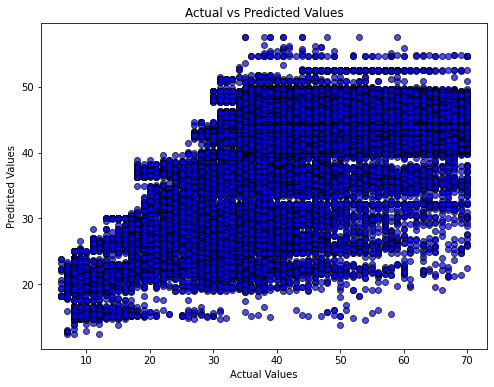

In [9]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ln, color='blue', edgecolor='k', alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

In [10]:
coefficients = reg_ln.coef_



importance = pd.DataFrame({'Variable': [f'X{i}' for i in range(X.shape[1])], 'Coefficient': coefficients})
importance['Absolute Coefficient'] = importance['Coefficient'].abs()
importance = importance.sort_values(by='Absolute Coefficient', ascending=False)

print(importance)

  Variable  Coefficient  Absolute Coefficient
6       X6     5.308567              5.308567
1       X1    -2.982522              2.982522
5       X5    -0.558520              0.558520
3       X3     0.553683              0.553683
7       X7    -0.148777              0.148777
4       X4     0.122830              0.122830
2       X2    -0.114220              0.114220
8       X8    -0.028598              0.028598
0       X0    -0.014184              0.014184


In [11]:
from sklearn.ensemble import RandomForestRegressor
reg_forest = RandomForestRegressor()
reg_forest.fit(X_train, y_train)

# Predict for the test data
y_pred_forest = reg_forest.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_forest)
r2 = r2_score(y_test, y_pred_forest)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 55.20
R-squared: 0.44


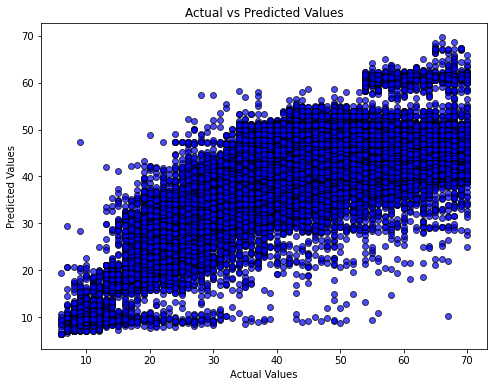

In [12]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_forest, color='blue', edgecolor='k', alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

In [13]:
from sklearn.svm import SVR
reg_SVR = SVR(kernel='sigmoid', max_iter=100, C = 1, epsilon = 0.5, gamma='scale')
reg_SVR.fit(X_train, y_train)

# Predict for the test data
y_pred_SVR = reg_SVR.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_SVR)
r2 = r2_score(y_test, y_pred_SVR)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

c:\Users\Zephyrus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 589.50
R-squared: -5.00


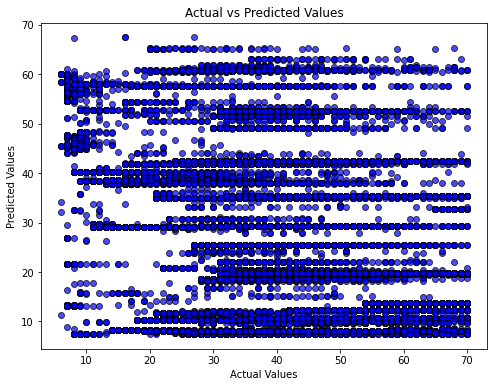

In [14]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_SVR, color='blue', edgecolor='k', alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Load data and train model
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, solver='sag', C=100))

model.fit(X_train, y_train)

# Predict for the test data
y_pred_log = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_log)
r2 = r2_score(y_test, y_pred_log)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

c:\Users\Zephyrus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Mean Squared Error: 122.24
R-squared: -0.25


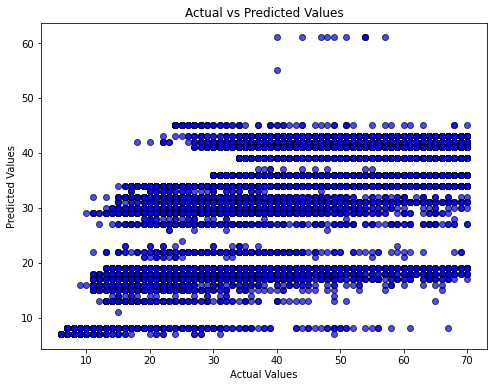

In [16]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_log, color='blue', edgecolor='k', alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()